<a href="https://colab.research.google.com/github/atryt0ne/cs690-multimodal-integration/blob/main/scMODAL_CCA_PBMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# scMODAL CCA PBMC

Demonstrates performance of scMODAL on the citeSeq PBMC dataset using CCA to identify additional linked variables

## Data Loading

In [ ]:
!git clone https://github.com/gefeiwang/scMODAL.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


fatal: destination path 'scMODAL' already exists and is not an empty directory.


In [ ]:
!cp -r scMODAL/scmodal scmodal

In [ ]:
!pip install anndata scanpy numba umap-learn torch annoy gdown

In [ ]:
!gdown 1ja8aXvTFcASyvNRDCosmXyXQaRG9XvmU

Downloading...
From: https://drive.google.com/uc?id=1ja8aXvTFcASyvNRDCosmXyXQaRG9XvmU
To: /kaggle/working/protein_gene_conversion.csv
100%|██████████████████████████████████████| 4.96k/4.96k [00:00<00:00, 14.6MB/s]


In [ ]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.io import mmread

In [ ]:
import requests, zipfile, io, os
local_zip_path = "maxfuse_data.zip"

# Check if the zip file already exists locally
if not os.path.exists(local_zip_path):
    # Download the zip file
    r = requests.get("http://stat.wharton.upenn.edu/~zongming/maxfuse/data.zip")
    with open(local_zip_path, 'wb') as f:
        f.write(r.content)

# Load the zip file from local storage
with zipfile.ZipFile(local_zip_path, 'r') as z:
    z.extractall("../")


In [ ]:
protein = pd.read_csv("../data/citeseq_pbmc/pro.csv") # 10k cells (protein)
# convert to AnnData
protein_adata = ad.AnnData(
    protein.to_numpy(), dtype=np.float32
)
protein_adata.var_names = protein.columns

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
rna = mmread("../data/citeseq_pbmc/rna.txt") # rna count as sparse matrix, 10k cells (RNA)
rna_names = pd.read_csv('../data/citeseq_pbmc/citeseq_rna_names.csv')['names'].to_numpy()
# convert to AnnData
rna_adata = ad.AnnData(
    rna.tocsr(), dtype=np.float32
)
rna_adata.var_names = rna_names

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [ ]:
metadata = pd.read_csv('../data/citeseq_pbmc/meta.csv')
labels_l1 = metadata['celltype.l1'].to_numpy()
labels_l2 = metadata['celltype.l2'].to_numpy()

protein_adata.obs['celltype.l1'] = labels_l1
protein_adata.obs['celltype.l2'] = labels_l2
rna_adata.obs['celltype.l1'] = labels_l1
rna_adata.obs['celltype.l2'] = labels_l2

## Linked Variables

In [ ]:
prot_gene = pd.read_csv('protein_gene_conversion.csv')
prot_gene.head()

,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG


In [ ]:
rna_protein_correspondence = []

for i in range(prot_gene.shape[0]):
    curr_protein_name, curr_rna_names = prot_gene.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

In [ ]:
len(rna_protein_correspondence)

180

In [ ]:
!gdown 1Js_jfhoNDIfZo1PJdOPud4vul_CkGQhY

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From: https://drive.google.com/uc?id=1Js_jfhoNDIfZo1PJdOPud4vul_CkGQhY
To: /kaggle/working/correlated_pairs.csv
100%|██████████████████████████████████████| 2.04k/2.04k [00:00<00:00, 10.4MB/s]


In [ ]:
correspondence = pd.read_csv('correlated_pairs.csv')
# correspondence = correspondence[['Protein Name', 'RNA Name']]
correspondence.shape[0]

150

In [ ]:
for i in range(min(correspondence.shape[0],10)):
    curr_protein_name, curr_rna_names = correspondence.iloc[i]
    if curr_protein_name not in protein_adata.var_names:
        continue
    if curr_rna_names.find('Ignore') != -1: # some correspondence ignored eg. protein isoform to one gene
        continue
    curr_rna_names = curr_rna_names.split('/') # eg. one protein to multiple genes
    for r in curr_rna_names:
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, curr_protein_name])

rna_protein_correspondence = np.array(rna_protein_correspondence)

In [ ]:
# Columns rna_shared and protein_shared are matched.
# One may encounter "Variable names are not unique" warning,
# this is fine and is because one RNA may encode multiple proteins and vice versa.
rna_shared = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
# Determine the indices of shared columns
shared_rna_indices = rna_protein_correspondence[:, 0]
shared_protein_indices = rna_protein_correspondence[:, 1]

# Identify the non-shared columns
all_rna_columns = np.array(rna_adata.var_names)
all_protein_columns = np.array(protein_adata.var_names)

non_shared_rna_indices = np.setdiff1d(all_rna_columns, shared_rna_indices)
non_shared_protein_indices = np.setdiff1d(all_protein_columns, shared_protein_indices)


# Reorder the columns so that shared columns come first
reordered_rna_adata = rna_adata[:, np.concatenate([shared_rna_indices, non_shared_rna_indices])]
reordered_protein_adata = protein_adata[:, np.concatenate([shared_protein_indices, non_shared_protein_indices])]

# Save the reordered AnnData objects as bmc_rna and bmc_protein
rna_adata = reordered_rna_adata
protein_adata = reordered_protein_adata

# Optionally, save the AnnData objects to files
rna_adata.write("proc_rna.h5ad")
protein_adata.write("proc_protein.h5ad")
print(f"Number of Shared Columns: {len(shared_rna_indices)}")

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
... storing 'celltype.l1' as categorical
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn

Number of Shared Columns: 180


In [ ]:
n_shared = len(shared_rna_indices)

## Preprocessing

In [ ]:
# row sum for RNA
rna_counts = rna_adata.X.sum(axis=1)
# row sum for protein
protein_counts = protein_adata.X.sum(axis=1)
# take median of each and then take mean
target_sum = (np.median(rna_counts.copy()) + np.median(protein_counts.copy())) / 2

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 20739 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


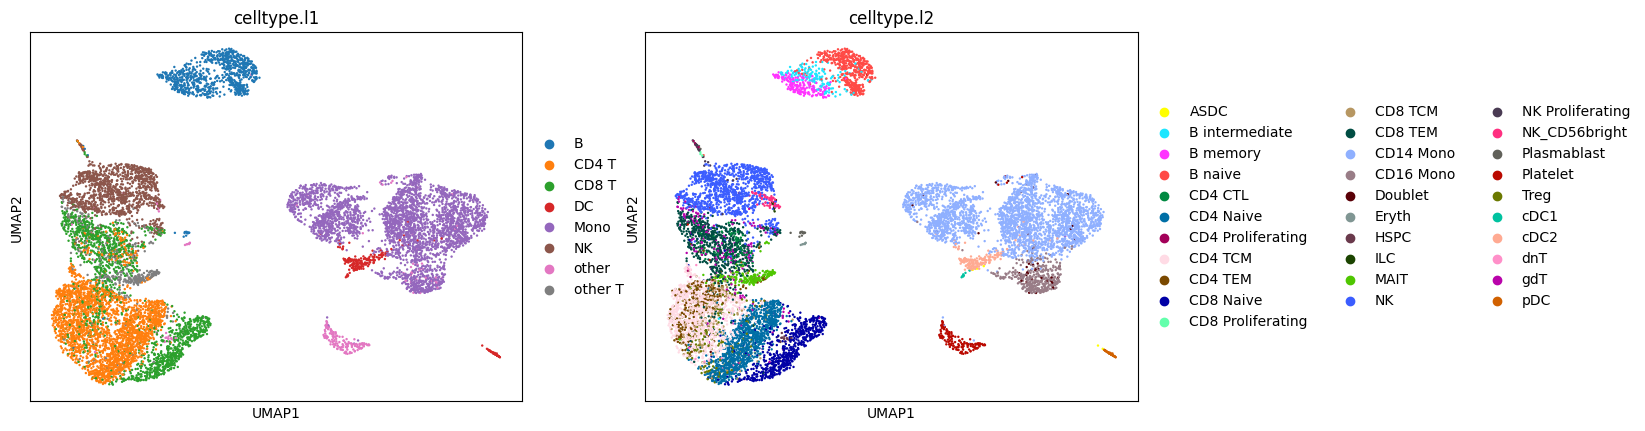

In [ ]:
# process rna_shared
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.scale(rna_adata)
# plot UMAPs of rna cells based only on rna markers with protein correspondence
sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata)
sc.pl.umap(rna_adata, color=['celltype.l1','celltype.l2'])

/opt/conda/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 234 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


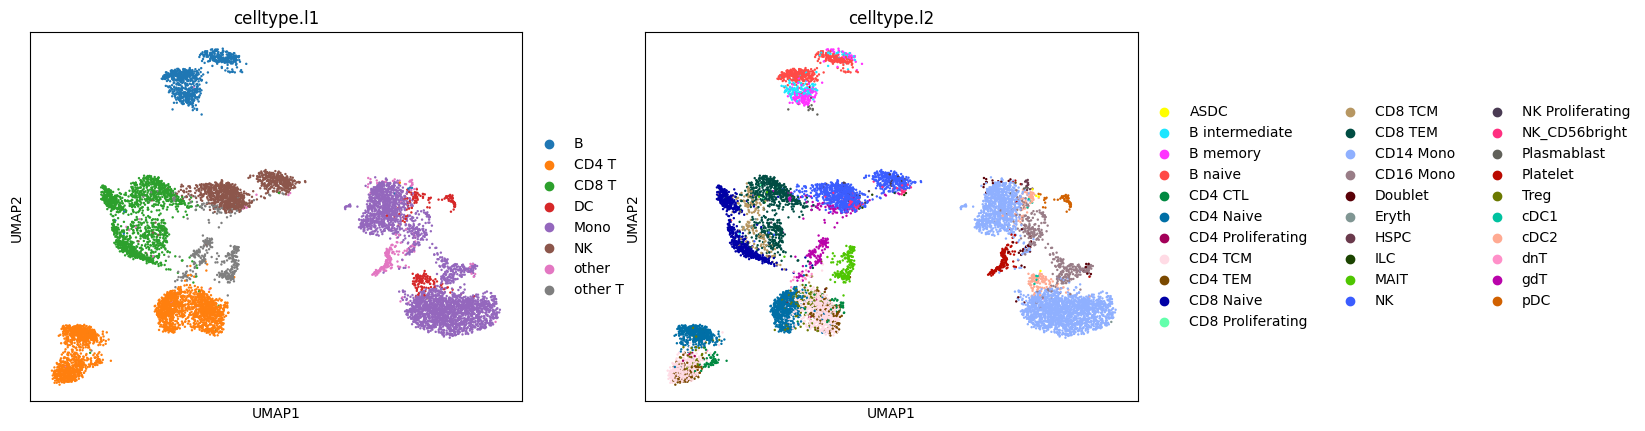

In [ ]:
# process protein_shared
sc.pp.normalize_total(protein_adata)
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)
# plot UMAPs of protein cells based only on protein markers with rna correspondence

sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata)
sc.pl.umap(protein_adata, color=['celltype.l1','celltype.l2'])

## Model Training

In [ ]:
import scmodal

model = scmodal.model.Model(training_steps=6000)
model.preprocess(rna_adata, protein_adata, shared_gene_num=n_shared)
model.train() # train the model
model.eval() # get integrated latent representation of cells

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Begining time:  Tue Nov 26 18:08:23 2024


OutOfMemoryError: CUDA out of memory. Tried to allocate 19.32 GiB. GPU 0 has a total capacity of 14.74 GiB of which 14.16 GiB is free. Process 2350 has 590.00 MiB memory in use. Of the allocated memory 228.33 MiB is allocated by PyTorch, and 227.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Model Evaluation

In [ ]:
adata_int = anndata.AnnData(X=model.latent)
adata_int.obs = pd.concat([rna_adata.obs, protein_adata.obs])
adata_int.obs['modality'] = ['RNA'] * rna_adata.shape[0] + ['ADT'] * protein_adata.shape[0]

scmodal.utils.compute_umap(adata_int)

### Integrated Representation

In [ ]:
sc.pl.umap(adata_int,color=['modality','celltype.l2'],save = 'umap.png')

### Label Transfer Accuracy

In [ ]:
from scipy.spatial.distance import cdist

dist_mtx = cdist(model.latent[rna_adata.shape[0]:, :],
                 model.latent[:rna_adata.shape[0], :],
                 metric='euclidean') # Transfer labels from RNA to ADT

matching = dist_mtx.argsort()[:, :1]

df1_labels = rna_adata.obs["celltype.l1"].values
df2_labels = protein_adata.obs["celltype.l1"].values

print("Label transfer accuracy: ", np.sum(df1_labels == df2_labels[matching.reshape(-1)]) / rna_adata.shape[0])

In [ ]:
df1_labels_2 = rna_adata.obs["celltype.l2"].values
df2_labels_2 = protein_adata.obs["celltype.l2"].values

print("Label transfer accuracy: ", np.sum(df1_labels_2 == df2_labels_2[matching.reshape(-1)]) / rna_adata.shape[0])

### FOSCTTM

In [ ]:
rna_cca, protein_cca = model.latent[rna_adata.shape[0]:, :], model.latent[:rna_adata.shape[0], :]

In [ ]:
def cdist_correlation(arr1, arr2):
    """Calculate pair-wise 1 - Pearson correlation between X and Y.

    Parameters
    ----------
    arr1: np.array of shape (n_samples1, n_features)
        First dataset.
    arr2: np.array of shape (n_samples2, n_features)
        Second dataset.

    Returns
    -------
    array-like of shape (n_samples1, n_samples2)
        The (i, j)-th entry is 1 - Pearson correlation between i-th row of arr1 and j-th row of arr2.
    """
    n, p = arr1.shape
    m, p2 = arr2.shape
    assert p2 == p

    arr1 = (arr1.T - np.mean(arr1, axis=1)).T
    arr2 = (arr2.T - np.mean(arr2, axis=1)).T

    arr1 = (arr1.T / np.sqrt(1e-6 + np.sum(arr1 ** 2, axis=1))).T
    arr2 = (arr2.T / np.sqrt(1e-6 + np.sum(arr2 ** 2, axis=1))).T

    return 1 - arr1 @ arr2.T

def get_foscttm(dist, true_matching='identity'):
    """
    Compute the fraction of samples closer than true match.

    Parameters
    ----------
    dist: np.ndarray of shape (n1, n2)
        Distance matrix.
    true_matching: 'identity' or Iterable of length n1, default='identity'
        If is a list, then the ground truth matched pairs are (i, true_matching[i])
        If is 'identity', then true_matching = [0, 1..., n1].

    Returns
    -------
    The fraction of samples closer than true match.
    """
    n1, _ = dist.shape
    if true_matching == 'identity':
        true_matching = np.arange(n1)
    elif isinstance(true_matching, Iterable):
        true_matching = [i for i in true_matching]
    else:
        raise NotImplementedError('true_matching must be \'identity\' or Iterable of length dist.shape[0].')
    # mask[i, j] = True iff dist[i, j] < dist[i, true_matching[i]]
    mask = (dist.T < dist[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))

dim_use = 15 # dimensions of the CCA embedding to be used for UMAP etc

get_foscttm(
    dist=cdist_correlation(rna_cca[:,:dim_use], protein_cca[:,:dim_use]),
    true_matching='identity'
)